 # Settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 그리기
%matplotlib inline

# 그래프 마이너스 폰트 깨지는 현상 해결을 위함
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'

In [3]:
# 폰트바뀌었는지 확인
print (plt.rcParams['font.family'] )

['NanumGothic']


In [4]:
train = pd.read_csv('C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/train.csv', parse_dates = ["datetime"])
train.shape

(10886, 12)

In [5]:
test = pd.read_csv('C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/test.csv', parse_dates = ["datetime"])
test.shape

(6493, 9)

 # Feature Engineering

In [6]:
# train 데이터에 'datetime'을 나누어 추가
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [7]:
# test 데이터에 "datetime"을 나누어 추가
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

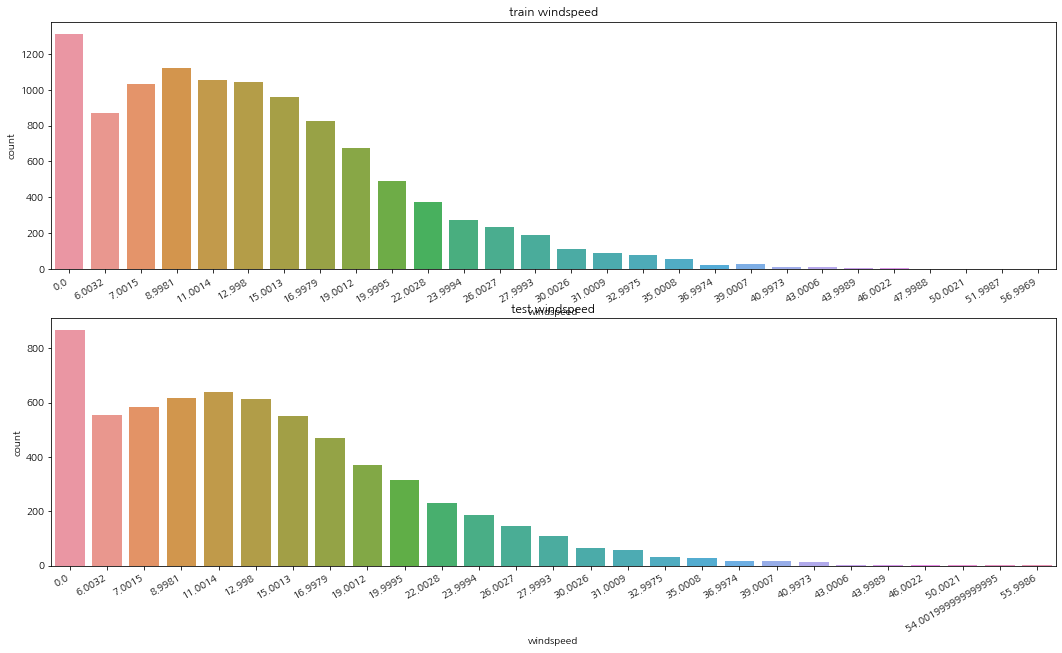

In [8]:
# "windspeed" 풍속 칼럼의 '0'값의 문제가 있는 것을 파악하기 위해 해당 칼럼의 값들을 시각화출력
fig, axes = plt.subplots(nrows = 2)
fig.set_size_inches(18, 10)

plt.sca(axes[0])
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel = 'Count', title = "train windspeed")
sns.countplot(data = train, x = "windspeed", ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30, ha = 'right')
axes[1].set(ylabel = 'Count', title = "test windspeed")
sns.countplot(data = test, x = "windspeed", ax = axes[1])

 * "windspeed"칼럼에 분석의 정확도를 올리기 위해 '0'에 특정 값을 넣는다. (결측값 처리, 이동평균 등과 같은 방법들이 존재)
 * 다음의 코드는 일괄적으로 평균을 집어넣는 방법
 * train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
 * test.loc[test["windspeed"] == 0, "windspeed"] = test["windspeed"].mean() 

In [9]:
 # 다음의 방법은 풍속이 '0'인 그룹과 아닌 그룹을 나누어 머신러닝으로 예측해 분석을 실시
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    #풍속이 '0'인 집단과 아닌 집단을 나눈다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 요인 선택
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    
    # 풍속이 '0'이 아닌 집단의 데이터 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    
    # 랜덤포레스트 사용
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 요인들을 풍속을 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
    
    # 학습한 값을 바탕으로 풍속이 '0'인 집단을 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 예측한 값을 비교하기 위해 새로운 데이터프레임을 만든다
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 '0'인 집단에 예측값을 대입
    predictWind0["windspeed"] = wind0Values
    
    # dataWindNot0 집단과 예측한 집단을 합친다.
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터 타입 float로 지정
    data["windspeed"] = data["windspeed"].astype("float")
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

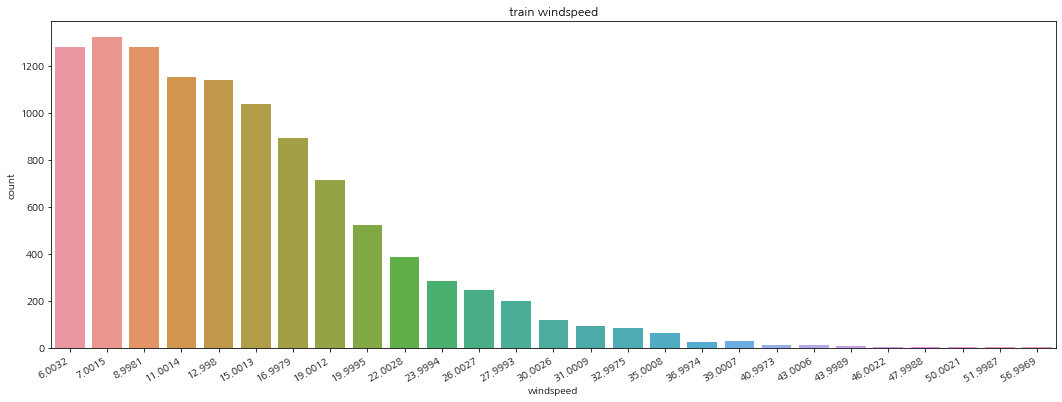

In [10]:
# 0값을 조정한다. ???
train = predict_windspeed(train)
# test = predict_windspeed(test)

# windspeed의 '0'값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right')    # 기울기
ax1.set(ylabel = 'Count', title = "train windspeed")
sns.countplot(data = train, x = "windspeed", ax = ax1)

 * '0'인 데이터가 사라진 것을 볼 수 있다.

In [11]:
# 연속형 변수와 이산형 변수가 데이터에 함께 존재.
# 연속형 변수 = temp, humidity, windspeed, atemp
# 나머지 변수는 이산형 변수이고 이것들의 데이터 타입을 category(범주형)로 변경한다.
categorical_feature_names = ["season", "holiday", "weather", "dayofweek", "month", "year", "hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [12]:
# 요인선택
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek",
                 "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [13]:
# 새로운 데이터 셋을 만든다.
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [14]:
# 마찬가지로 새로운 데이터 셋을 만든다.
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [15]:
# 카운트 칼럼 추출 (아마도 일일 자전거 대여 횟수)
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [16]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,0,0,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,0,0,5


# 모델평가 공식 (RMSLE)

In [21]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    # 넘파이로 배열 형태로 전환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 르그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 더해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

 # K-Fold 교차검증

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

 # RandomForest

In [39]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators = 1000,
                              n_jobs = -1,
                              random_state = 0)

model
# n_estimators는 의사결정 트리 개수
# n_jobs는 cpu 코어를 전부 사용
# random_state시드 값

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [40]:
%time score = cross_val_score(model, X_train, y_train, cv = k_fold, scoring = rmsle_scorer)
score = score.mean()
# '0'에 근접할수록 좋은 데이터
print("Score = {0:.5f}".format(score))

Wall time: 2min 32s
Score = 0.32944


In [41]:
# 학습, 모형 피팅
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [42]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0: 10]

(6493,)


array([ 11.808,   4.919,   4.014,   3.536,   2.961,   6.581,  38.278,
       106.955, 240.027, 136.865])

[Text(0.5, 1.0, 'test')]

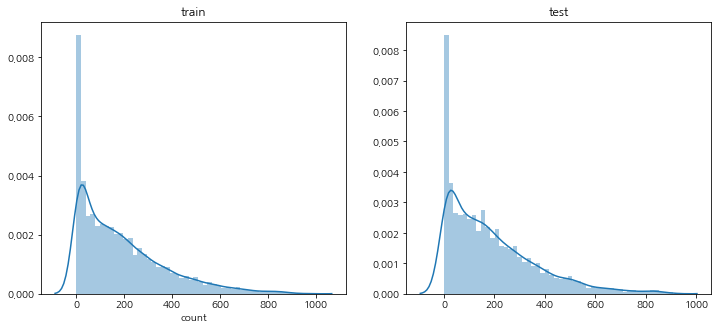

In [43]:
# 예측한 데이터를 시각화
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12, 5)
sns.distplot(y_train, ax = ax1, bins =50)
ax1.set(title = "train")
sns.distplot(predictions, ax = ax2, bins = 50)
ax2.set(title = "test")

# bins는 막대너비 클수록 자세하게 나옴

 # Submit

In [44]:
submission = pd.read_csv("C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.808
1,2011-01-20 01:00:00,4.919
2,2011-01-20 02:00:00,4.014
3,2011-01-20 03:00:00,3.536
4,2011-01-20 04:00:00,2.961


In [45]:
submission.to_csv("C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/Score_{0:.5f}_submission.csv".format(score), 
                 index = False)